# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [97]:
import io
import os
import numpy as np
import scipy
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
import matplotlib.pyplot as plt

In [83]:
PATH_TO_DATA = "/Users/gregoire/Documents/MVA/Deep Learning/nlp_project/data/"
#PATH_TO_DATA = "../../data/"

# 1) Monolingual (English) word embeddings 

In [84]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = dict.fromkeys(self.word2vec.keys())
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            i=0
            for line in f:
                word, vec = line.split(' ', 1)
                word = word.lower() # Lower the word to avoid
                
                if word not in self.word2vec:
                    self.word2vec[word] = np.fromstring(vec, sep=' ')
                    i += 1
                    
                if i == nmax:
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        
        # List of available words
        words = list(self.word2vec.keys())
        # Compute similarities
        similarities = np.array([self.score(w, word) for word in words])
        # Indexes of words by decreasing similarity
        #Remove first word, and keep the K following
        most_similar_words = np.argsort(-similarities)[1:K+1]
        
        return [words[idx] for idx in most_similar_words]
    
    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        # Get the vectors corresponding to words w1 and w2
        vec_w1 = self.word2vec[w1]
        vec_w2 = self.word2vec[w2]
        
        return np.dot(vec_w1, vec_w2) / (np.linalg.norm(vec_w1) * np.linalg.norm(vec_w2))

In [85]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=25000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 25000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7058595452409975
germany berlin 0.7060253015336013
['cats', 'kitten', 'feline', 'kitties', 'dog']
['dogs', 'puppy', 'doggie', 'canine', 'pup']
['dog', 'puppies', 'cats', 'canine', 'pets']
['parisian', 'france', 'marseille', 'louvre', 'versailles']
['austria', 'bavaria', 'berlin', 'munich', 'german']


In [86]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        # see TP1 for help
        sentemb = []
        dim = list(w2v.word2vec.values())[0].shape

        for sent in sentences:
            
            if idf is False:
                # ignore unknowm words
                word_vectors = [self.w2v.word2vec[w] for w in sent.split() if w in self.w2v.word2vec]
                
                if len(word_vectors)==0:
                    # If no words are knowm, null vector
                    mean = np.zeros(dim)
                else:
                    # mean of word vectors
                    mean = np.mean(word_vectors, axis=0)
                    
                sentemb.append(mean)
            else:
                # ignore unknowm words
                weighted_word_vectors = [idf[w] * self.w2v.word2vec[w]
                                         for w in sent.split() if w in self.w2v.word2vec and w in idf]
        
                if len(weighted_word_vectors)==0:
                    # If no words are knowm, null vector
                    weighted_mean = np.zeros(dim)
                else:
                    # idf-weighted mean of word vectors
                    weighted_mean = np.mean(weighted_word_vectors, axis=0)
                
                sentemb.append(weighted_mean)
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences[:50], idf)
        query = self.encode([s], idf).squeeze()

        # Compute similarities
        similarities = np.array([self.score(query, key) for key in keys])

        # Indexes of sentences by decreasing similarity
        # Remove first sentence, and keep the K following
        indexes_most_similar_sentences = np.argsort(-similarities)[1:K+1]
        
        most_similar_sentences = [sentences[idx] for idx in indexes_most_similar_sentences]
        
        print('\n#{} Most similar sentences to "{}" :'.format(K, s))
        for i, sent in enumerate(most_similar_sentences):
            print('{}) "{}"'.format(i+1, sent))
        
        return most_similar_sentences

    def score(self, s1, s2, idf=False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        try:
            return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))
        except:
            vec_s1 = self.encode([s1], idf).squeeze()
            vec_s2 = self.encode([s2], idf).squeeze()
            print(np.linalg.norm(vec_s1), np.linalg.norm(vec_s2))
            return np.dot(vec_s1, vec_s2) / (np.linalg.norm(vec_s1) * np.linalg.norm(vec_s2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        idf = {}
        
        for sent in sentences:
            for w in set(sent):
                idf[w] = idf.get(w, 0) + 1
        
        for w in idf.keys():
            idf[w] = max(1, np.log10(len(sentences) / (idf[w])))
            
        return idf

In [87]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=5000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
with open(os.path.join(PATH_TO_DATA, 'sentences.txt'), 'r') as filehandle:  
    sentences = [current_place.rstrip() for current_place in filehandle.readlines()]

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
print('\n', s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = {}  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print('\n', s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 5000 pretrained word vectors

#5 Most similar sentences to "1 smiling african american boy ." :
1) "2 african adults and 8 african children looking at pictures on a table ."
2) "2 african american men in a green military uniform of some sort are standing in an archway , while one of the men is giving a thumbs up ."
3) "2 black children in a foreign country , carrying a jug of water ."
4) "2 asian men are sweeping flower petals off of some stairs ."
5) "2 older women and a young girl with a red bike ."
1.6388323539989955 1.6606708154303855

 0.6089445116147133

#5 Most similar sentences to "1 smiling african american boy ." :
1) "2 older women and a young girl with a red bike ."
2) "2 people with white hats looking over the mountain"
3) "2 villagers carry a baskets of goods while another follows ."
4) "2 adult men lying on a floor ."
5) "2 adults snorkeling in the ocean ."
0.0 0.0

 nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [88]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

# TYPE CODE HERE
w2v_fr = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.fr.vec'), nmax=50000)
w2v_en = Word2vec(os.path.join(PATH_TO_DATA, 'wiki.en.vec'), nmax=50000)

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


In [89]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

# TYPE CODE HERE
common_words = [w for w in w2v_fr.word2vec if w in w2v_en.word2vec]

X = np.vstack([w2v_fr.word2vec[w] for w in common_words]).T
Y = np.vstack([w2v_en.word2vec[w] for w in common_words]).T

In [90]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

# TYPE CODE HERE
from scipy.linalg import svd

U, S, V = svd(np.dot(Y, X.T))
W = U.dot(V)

In [91]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

# TYPE CODE HERE

def score(w1, w2):
    return np.dot(w1, w2) / (np.linalg.norm(w1) * np.linalg.norm(w2))
        
def nearest_neighbors(W, word, w2v_fr, w2v_en, lang_input='fr', K=5):
    
    if lang_input=='fr':
        projection = lambda vec: W.dot(vec)
        w2v_input = w2v_fr
        w2v_output = w2v_en
    elif lang_input=='en':
        projection = lambda vec: W.T.dot(vec)
        w2v_input = w2v_en
        w2v_output = w2v_fr
    else:
        return 'Error: Unknown language'
    
    # Get the embedding of the word we want to translate
    vec_word_input = w2v_input.word2vec[word]
    vec_word_output = projection(vec_word_input)
        
    # List of available words
    words = list(w2v_output.word2vec.keys())
    
    # Compute similarities 
    similarities = []
    for key in words:
        vec_key_output = w2v_output.word2vec[key]
        similarities.append(score(vec_word_output, vec_key_output))
    
    
    # Indexes of words by decreasing similarity
    #Remove first word, and keep the K following
    most_similar_words = np.argsort(-np.array(similarities))[:K]
    
    return [words[idx] for idx in most_similar_words]

K=5

for word in ['soleil', 'loup', 'maman']:
    print('The {} english neareast neighbors of the french word "{}" are :'.format(K, word))
    print('\t', nearest_neighbors(W, word, w2v_fr, w2v_en, 'fr', K))

print('=============')          

for word in ['father', 'beer', 'priest']:
    print('The {} french neareast neighbors og the english word "{}" are :'.format(K, word))
    print('\t', nearest_neighbors(W, word, w2v_fr, w2v_en, 'en', K))

The 5 english neareast neighbors of the french word "soleil" are :
	 ['sun', 'ecliptic', 'perihelion', 'soleil', 'solstice']
The 5 english neareast neighbors of the french word "loup" are :
	 ['wolf', 'loup', 'boar', 'raccoon', 'ferret']
The 5 english neareast neighbors of the french word "maman" are :
	 ['grandma', 'mom', 'mommy', 'mama', 'baby']
The 5 french neareast neighbors og the english word "father" are :
	 ['père', 'fils', 'oncle', 'frère', 'aîné']
The 5 french neareast neighbors og the english word "beer" are :
	 ['bière', 'bières', 'boisson', 'vodka', 'alcoolisée']
The 5 french neareast neighbors og the english word "priest" are :
	 ['prêtre', 'vicaire', 'diacre', 'prêtres', 'évêque']


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [92]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# TYPE CODE HERE
PATH_TO_SST = PATH_TO_DATA + 'SST/'

def read_sst_file(file_name):
    # Initialize datasets
    sentences = []
    labels = []
    
    # Create file path and recognize type
    file_path = os.path.join(PATH_TO_SST, file_name)
    test = ('test' in file_name)
    
    # Open file and store the sentences (and labels)
    with open(file_path, 'r') as file:
        for line in file: 
            if test:
                sentence = line
            else:
                label, sentence = line.split(' ', 1)
                labels.append(int(label))
            sentences.append(sentence)
            
    return sentences, labels
                

S_train, y_train = read_sst_file('stsa.fine.train')
S_dev, y_dev = read_sst_file('stsa.fine.dev')
S_test, _ = read_sst_file('stsa.fine.test.X')

In [93]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=-1)
s2v = BoV(w2v)

# Build idf scores for each word
idf = s2v.build_idf(S_train)

# Encode with idf
X_train_idf = s2v.encode(S_train, idf)
X_dev_idf = s2v.encode(S_dev, idf)
X_test_idf = s2v.encode(S_test, idf)

# Encode without idf
X_train = s2v.encode(S_train)
X_dev = s2v.encode(S_dev)
X_test = s2v.encode(S_test)

Loaded 146559 pretrained word vectors


In [94]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# TYPE CODE HERE

def evaluate_logistic_regression(X_train, y_train, X_dev, y_dev, cross_validation=False):
    cross_validation = False

    if cross_validation:
        lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
        grid = {
            'C': np.logspace(-1.5, 1.5, 100),
            'max_iter': randint(50, 1000)
        }

        print('>> Doing cross validation...')
        sk = StratifiedKFold(n_splits=3, shuffle=True)
        cv = RandomizedSearchCV(estimator=lr, cv=sk, n_jobs=-1, n_iter=50, param_distributions=grid, verbose=2)
        cv.fit(X_train, y_train)
        model = cv.best_estimator_
        print('... Done')

    else:
        print('>> Fitting the model...')
        model = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=0.38986037025490716, max_iter=500, random_state=42)
        model.fit(X_train, y_train)
        print('... Done')
    
        print('Train score: ', model.score(X_train, y_train))
        print('Test score: ', model.score(X_dev, y_dev))
        
    return model
        
print('Without idf :')
model = evaluate_logistic_regression(X_train, y_train, X_dev, y_dev)
print('\nWith idf :')
_ = evaluate_logistic_regression(X_train_idf, y_train, X_dev_idf, y_dev)

Without idf :
>> Fitting the model...
... Done
Train score:  0.48911516853932585
Test score:  0.4359673024523161

With idf :
>> Fitting the model...
... Done
Train score:  0.29084737827715357
Test score:  0.3006357856494096


In [95]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
y_pred = model.predict(X_test).astype(int)
np.savetxt('logreg_bov_y_test_sst.txt', y_pred, fmt='%d')

In [98]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

# The best performance that I achieved was 0.40 in test with Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test).astype(int)
np.savetxt('gaussian_bov_y_test_sst.txt', y_pred, fmt='%d')

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [14]:
import keras

In [73]:
# 1 - Load train/dev/test sets of SST
PATH_TO_DATA = "../../data/"

# TYPE CODE HERE
S_train, y_train = read_sst_file('stsa.fine.train')
S_dev, y_dev = read_sst_file('stsa.fine.dev')
S_test, _ = read_sst_file('stsa.fine.test.X')

In [74]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import one_hot
nb_max_words = 1000

S_train = [one_hot(s, nb_max_words) for s in S_train]
S_dev = [one_hot(s, nb_max_words) for s in S_dev]
S_test = [one_hot(s, nb_max_words) for s in S_test]

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [75]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

max_length = max(max(S_train, key=len))

S_train = pad_sequences(S_train, max_length)
S_dev = pad_sequences(S_dev, max_length)
S_test = pad_sequences(S_test, max_length)

## 4.2 - Design and train your model

In [76]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = nb_max_words  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout_W=0.25, dropout_U=0.3))
model.add(Dense(n_classes, activation='sigmoid'))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, dropout=0.25, recurrent_dropout=0.3)`


In [77]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          32000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 57,157
Trainable params: 57,157
Non-trainable params: 0
_________________________________________________________________
None


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 242s 28ms/step - loss: 1.5780 - acc: 0.2674 - val_loss: 1.5726 - val_acc: 0.2534
Epoch 2/10
8544/8544 [==============================] - 227s 27ms/step - loss: 1.5585 - acc: 0.2816 - val_loss: 1.5543 - val_acc: 0.2952
Epoch 3/10
8544/8544 [==============================] - 229s 27ms/step - loss: 1.4935 - acc: 0.3352 - val_loss: 1.4904 - val_acc: 0.3497
Epoch 4/10
8544/8544 [==============================] - 214s 25ms/step - loss: 1.4104 - acc: 0.3825 - val_loss: 1.4903 - val_acc: 0.3506
Epoch 5/10
8544/8544 [==============================] - 231s 27ms/step - loss: 1.3618 - acc: 0.4029 - val_loss: 1.4892 - val_acc: 0.3524
Epoch 6/10
8544/8544 [==============================] - 253s 30ms/step - loss: 1.3263 - acc: 0.4216 - val_loss: 1.5152 - val_acc: 0.3551
Epoch 7/10
8544/8544 [==============================] - 241s 28ms/step - loss: 1.2942 - acc: 0.4311 - val_loss: 1.5334 - val_acc: 

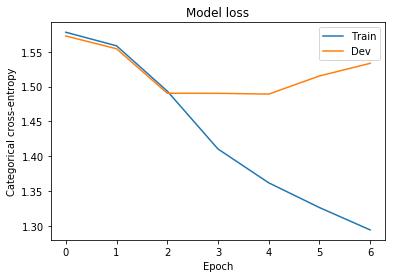

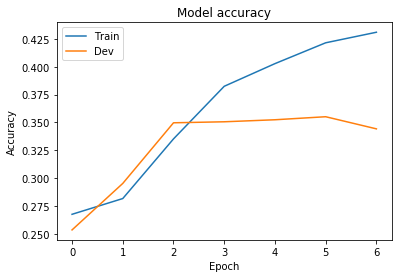

In [78]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

bs = 64
n_epochs = 10

y_train = to_categorical(y_train, num_classes=n_classes)
y_dev = to_categorical(y_dev, num_classes=n_classes)

callbacks = [EarlyStopping(monitor='val_loss', patience=2)]

history = model.fit(S_train, y_train,
                    batch_size=bs,
                    nb_epoch=n_epochs,
                    validation_data=(S_dev, y_dev),
                    verbose=1,
                    callbacks=callbacks)

# Plot the categorical Cross-entropy
plt.figure(1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Dev')
plt.title('Model loss')
plt.ylabel('Categorical cross-entropy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the accuracy
plt.figure(2)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Dev')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [54]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
y_pred = model.predict(S_test).astype(int)
np.savetxt('logreg_lstm_y_test_sst.txt', y_pred, fmt='%dt')

## 4.3 -- innovate !

In [ ]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
